# **Explain Like I'm Not a Scientist**
### *An exploration of (not so) scientific communication*
| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Emily K. Sanders| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Project 3: NLP|
|DSB-318| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |May 3, 2024|
---
###### *A report for the 2024 Greater Lafayette Association for Data Science Conference on Activism for a Thriving Society*

## Prior Notebooks Summary

In the previous notebooks, I introduced the purpose of this work and gave an overview of the data collection procedures.

In this notebook, I will explain my feature engineering process.

In [2]:
# Imports
import pandas as pd
import requests
import getpass
from datetime import date, time, datetime
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

## Method: Feature engineering

After scraping and processing all of the posts and comments, I concatenated them together into one dataframe.  This is reproduced below with the same data generated in the previous two workbooks.  The actual concatenated dataframe is available in the `data/input` folder, in the `combined-df.zip` folder.  By the end of this workbook, the dataframe will be a more managable size to be stored in GitHub, and I will be able to abandon the example data.

In [3]:
# Generate a list of CSVs
wholes = os.listdir('../data/output/concatted-wholes')
wholes = [w for w in wholes if w.split('.')[-1]=='csv']
len(wholes)

2

In [4]:
# Import and concatenate all data
hold = []
for file in wholes:
  path = "../data/output/concatted-wholes/" + file
  df = pd.read_csv(path)
  hold.append(df)
scrapes = pd.concat(hold, sort=False, axis=0, join='outer', ignore_index=True)

# Drop any duplicates
scrapes.drop_duplicates(
  subset = 'permalink', keep = 'first', inplace = True, ignore_index = True)
scrapes.shape

(59, 126)

I then used `.describe()` to validate that none of the columns had irregular values.  Because it would be pointless to look at the `.describe()` of a tiny dataset for illustration purposes only, I have imported the real one below.  

In [5]:
combined_df_describe = pd.read_csv("../data/output/combined_df_describe.csv")
pd.set_option('display.max_columns', None)
combined_df_describe

,Unnamed: 0.1,Unnamed: 0,all_awardings,approved_at_utc,approved_by,archived,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,banned_at_utc,banned_by,body,body_html,can_gild,can_mod_post,collapsed,collapsed_because_crowd_control,collapsed_reason,collapsed_reason_code,comment_type,controversiality,created,created_utc,depth,distinguished,downs,edited,gilded,gildings,id,is_submitter,likes,link_id,locked,mod_note,mod_reason_by,mod_reason_title,mod_reports,name,no_follow,num_reports,parent_id,permalink,removal_reason,replies,report_reasons,saved,score,score_hidden,send_replies,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,top_awarded_type,total_awards_received,treatment_tags,unrepliable_reason,ups,user_reports,kind,source,date_scraped,scrape_num,ridiculous,unreasonable,allow_live_comments,category,clicked,content_categories,contest_mode,discussion_type,domain,hidden,hide_score,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_text,link_flair_text_color,link_flair_type,media,media_embed,media_only,num_comments,num_crossposts,over_18,parent_whitelist_status,pinned,pwls,quarantine,removed_by,removed_by_category,secure_media,secure_media_embed,selftext,selftext_html,spoiler,subreddit_subscribers,suggested_sort,thumbnail,title,upvote_ratio,url,view_count,visited,whitelist_status,wls,crosspost_parent,crosspost_parent_list,url_overridden_by_dest,author_cakeday,link_flair_template_id
0,count,9646,9646,0.0,0.0,9646,0.0,9646,27,590,9446,550,591,792,9446,9446,9646,9446,9446,9646,0.0,0.0,7878,7878,9646,9646,7878,0.0,84,198,0.0,7878.000000,9.646000e+03,9.646000e+03,7878.0,11,9646.0,9646,9646.0,9646,9646,7878,0.0,7878,9646,0.0,0.0,0.0,9646,9646,9646,0.0,7878,9646,0.0,2978,0.0,9646,9646.000000,7878,9646,9646,9646,9646,9646,9646,0.0,9646.0,9646,0.0,9646.000000,9646,9646,9646,9447,9447,0.0,0.0,1768,0.0,1768,0.0,1768,0.0,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,740,740,1768,740,1768,1768,0.0,1768,1768,1768.000000,1768.000000,1768,1768,1768,1768.0,1768,0.0,0.0,0.0,1768,1461,1461,1768,1.768000e+03,740,0.0,1768,1768.000000,1768,0.0,1768,1768,1768.0,6,6,6,7,740
1,unique,119,1,NaN,NaN,1,NaN,6006,3,9,8,34,41,1,2,6005,1,1,2,1,NaN,NaN,7714,7714,1,1,2,NaN,1,2,NaN,NaN,NaN,NaN,NaN,1,NaN,724,NaN,1,9646,2,NaN,1086,2,NaN,NaN,NaN,1,9646,2,NaN,1086,9646,NaN,2978,NaN,1,NaN,2,2,2,2,2,2,1,NaN,NaN,1,NaN,NaN,1,2,4,6,531,NaN,NaN,2,NaN,1,NaN,1,NaN,5,1,2,1,1,1,1,1,1,2,1,9,9,10,9,2,2,NaN,1,1,NaN,NaN,2,1,1,NaN,1,NaN,NaN,NaN,1,1457,1457,1,NaN,1,NaN,1764,NaN,1768,NaN,1,1,NaN,6,6,6,1,9
2,top,data,[],NaN,NaN,False,NaN,[deleted],#ffd635,inter,[],8c5fb068-c6b2-11e4-b8be-22000bb30918,Education and outreach,dark,text,t2_16nhu9,False,False,False,[],NaN,NaN,[removed],"&lt;div class=""md""&gt;&lt;p&gt;[removed]&lt;/p...",False,False,False,NaN,comment score below threshold,DELETED,NaN,NaN,NaN,NaN,NaN,moderator,NaN,False,NaN,{},l171gyd,False,NaN,t3_1c78be1,False,NaN,NaN,NaN,[],t1_l171gyd,True,NaN,t3_1c78be1,/r/AskPhysics/comments/1ccqsca/why_is_there_on...,NaN,"{'kind': 'Listing', 'data': {'after': None, 'd...",NaN,False,NaN,False,True,False,explainlikeimfive,t5_2sokd,r/explainlikeimfive,public,NaN,NaN,[],NaN,NaN,[],t1,eli5-comments,2024-04-28,unknown,NaN,NaN,False,NaN,False,NaN,False,NaN,self.AskPhysics,False,False,False,True,False,False,False,True,True,False,#007373,Biology,[],Biology,dark,text,NaN,{},False,NaN,NaN,False,all_ads,False,NaN,False,NaN,NaN,NaN,{},I found this jack with a capacity of 880 pound...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",False,NaN,confidence,NaN,Would this jack hold up and or be safe?,NaN,https://www.reddit.com/r/AskPhysics/comments/1...,NaN,Fa

All of the values look reasonable.  The empty columns were of no concern, as I dropped most of them anyway.  My purpose in the current work is to focus on the text.  I dropped the majority of columns first, tinkered with some of the others, and then reduced again down to my final X and y variables.

In [6]:
# Drop columns
scrapes = scrapes[['body', 'selftext', 'title', 'kind', 'source', 'subreddit']]
scrapes.shape

(59, 6)

In the previous notebook, some comments had to handled with care because they were missing column headers and/or had extra columns.  These rows lost their `['source']` column in the process.  Below, I have filled it in.

In [7]:
scrapes['source'].value_counts(dropna = False)

source
NaN              34
eli5-comments    11
askp-comments     6
askp              4
eli5              4
Name: count, dtype: int64

In [8]:
scrapes.loc[((scrapes['subreddit']=='AskPhysics') & (scrapes['source'].isna())), 'source'] = 'askp-comments'
scrapes.loc[((scrapes['subreddit']=='explainlikeimfive') & (scrapes['source'].isna())), 'source'] = 'eli5-comments'

In [9]:
scrapes['source'].value_counts(dropna = False)

source
eli5-comments    44
askp-comments     7
askp              4
eli5              4
Name: count, dtype: int64

Of the remaining columns, `['body']` and `['selftext']` both refer to the text within a post or comment.  For posts it is called `selftext`, and for comments it is called `body`.  Because I was comparing both types together across the subreddits, I combined these two columns.  

In [10]:
# Observe the pattern of null values
scrapes.isnull().groupby(scrapes['source']).sum()

,body,selftext,title,kind,source,subreddit
source,,,,,,
askp,4,0,0,0,0,0
askp-comments,0,7,7,0,0,0
eli5,4,1,0,0,0,0
eli5-comments,0,44,44,0,0,0


In [11]:
# Define a column to act like a mask
scrapes['has_body'] = scrapes['body'].notna()

# Fill the null values
for i in list(range(len(scrapes['has_body']))):
  if scrapes.loc[i, 'has_body']==True:
    continue
  else:
    scrapes.loc[i, 'body'] = scrapes.loc[i, 'selftext']

In [12]:
# Observe the new pattern of null values
scrapes.isnull().groupby(scrapes['source']).sum()

,body,selftext,title,kind,source,subreddit,has_body
source,,,,,,,
askp,0,0,0,0,0,0,0
askp-comments,0,7,7,0,0,0,0
eli5,1,1,0,0,0,0,0
eli5-comments,0,44,44,0,0,0,0


(Recall that some eli5 posts have only titles, and no text.)

Because the only remaining null values are in text columns, and because I knew that those missing values were merely artifacts of how the reddit API organizes the informtion, I filled them with empty strings.  I then combined the `['title']` column with the `['body']` column, to result in a single column of text for analysis.

In [13]:
# Fill missing values
scrapes.fillna('', inplace = True)

# Combine the columns
scrapes['text'] = scrapes['title'] + scrapes['body']

# Check null values and dtypes
scrapes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       59 non-null     object
 1   selftext   59 non-null     object
 2   title      59 non-null     object
 3   kind       59 non-null     object
 4   source     59 non-null     object
 5   subreddit  59 non-null     object
 6   has_body   59 non-null     bool  
 7   text       59 non-null     object
dtypes: bool(1), object(7)
memory usage: 3.4+ KB


I then dropped the superfluous columns.  I kept `['source']` over `['subreddit']` to preserve the post/comment distinction for EDA, but I collapsed them into just the subreddits before analysis.

In [14]:
scrapes = scrapes[['text', 'source']]
scrapes.shape

(59, 2)

At this point, the true dataframe was small enough to be supported by GitHub.

In [15]:
scrapes = pd.read_csv('../data/input/final-df.csv')
scrapes.head(2)

,source,text
0,askp-comments,Yes it does make sense to ask why and the answ...
1,askp-comments,Edit: by God how do I LaTeX? (Edit2: workaroun...


## Exploratory Data Analysis

As mentioned before, the imbalance in my classes started out as 1028 AskPhysics posts to 740 eli5 posts, but once the comments were scraped, it reversed.  Here is that distribution.

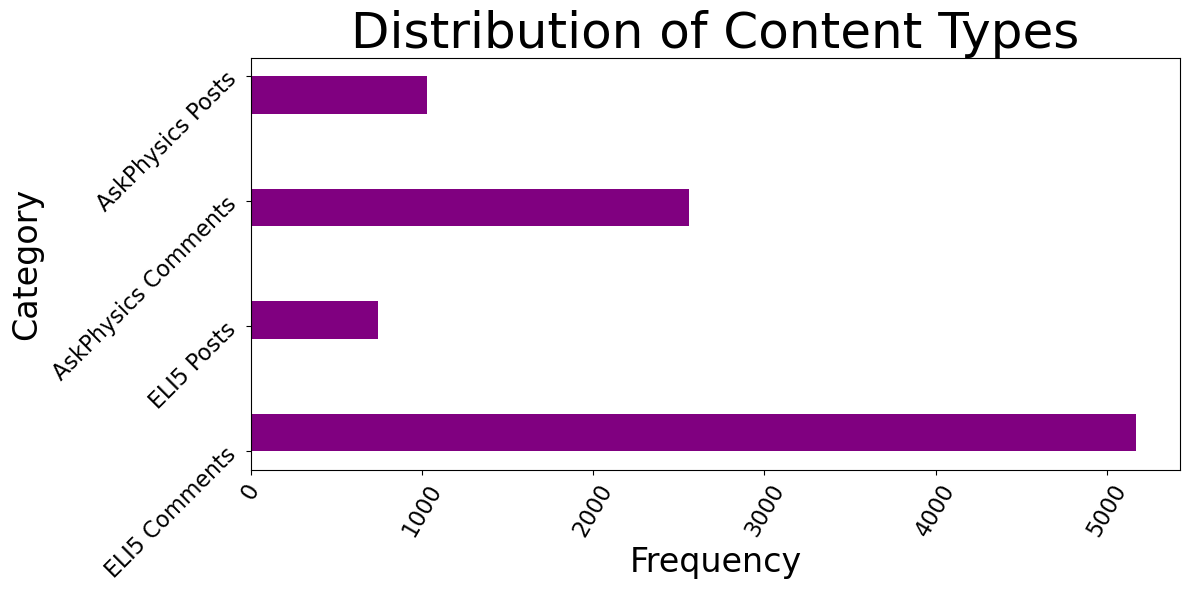

In [16]:
# Plot a bar graph
plt.figure(figsize = (12, 6));
plt.hist(scrapes['source'].sort_values(ascending = False), orientation = 'horizontal', color = 'purple');
plt.title(f'Distribution of Content Types', size = 36)
plt.xlabel('Frequency', size = 24);
plt.ylabel('Category', size = 24);
plt.xticks(size = 16, rotation = 60);
# Thanks to the documentation for this syntax
plt.yticks(np.arange(4), 
           labels = ['ELI5 Comments', 'ELI5 Posts', 'AskPhysics Comments', 'AskPhysics Posts'], 
           size = 16, rotation = 45)
plt.tight_layout()
plt.savefig('../images/graphs/distribution-of-types.png')

#### Counts by Category

|        |ELI5|AskPhysics|Total|
|--------|----|----------|-----|
|Posts   | 740 (7.8%) | 1028 (10.8%) | 1768 (18.6%) |
|Comments| 5170 (54.4%) | 2557 (26.9%) | 7727 (81.4%) |
|Total   | 5910 (62.2%) | 3585 (37.8%) | 9495 (100%) |
---

Based on these values, the baseline score to beat is 62.2%.  If the model classifid all observations as belonging to eli5, this is how often it would be correct.  Given the proliferation of comments I observed on eli5, I am inclined to speculate that eli5 is indeed the true "majority class," even if the exact ratio in my sample may or may not be representative.

In [19]:
scrapes['source'].value_counts()

source
eli5-comments    5170
askp-comments    2557
askp             1028
eli5              740
Name: count, dtype: int64

In [20]:
scrapes['source'].value_counts(normalize = True)

source
eli5-comments    0.544497
askp-comments    0.269300
askp             0.108268
eli5             0.077936
Name: proportion, dtype: float64

As the graph above demonstrates, I was able to gather 9495 unique texts from my chosen subreddits, including post titles, post bodies, and comment bodies.  The posts are imbalanced in favor of AskPhysics, but the balance changed when I added the comments.  Not only did the balance of subreddits reverse (5910 eli5, 3585 AskPhysics), but the comments (n = 7727) vastly outnumbered the posts (n = 1768).  The eli5 comments alone comprise over 54% of the sample.  For ths reason, I decided to stratify my train test split.  This will be explored in the next notebook.

In this notebook, I engineered my features and demonstrated the imbalance of the classes.  In the next notebook, I will conduct my train test split and modeling.